In [1]:
import torch 
from torch import optim
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import sys

sys.path.append('..')
from datasets import COCOADatasetGraph, COCOADatasetDual

from Trainer import MaskTrainer, DualMaskTrainer
from UNet import UNet, UNetDual

/home/kenchen10/.conda/envs/py38/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)
DUAL = False # segmentation + graph
classification = True # for graph
hingeloss = True
C = 8       # Number of channels in graph

cpu


/home/kenchen10/.conda/envs/py38/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 101: invalid device ordinal (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Data

In [3]:
def COCOADataset(phase, transform=None, classification=classification):
    root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}
    img_root = root_dict[phase]
    annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)
    graph_root = "../data/COCOA/pixel_graphs_{}/".format(phase)
#     if hingeloss:
#         classification = True 
    if DUAL:
        return COCOADatasetDual(annot_path, img_root, graph_root, transform=transform, classification=classification)
    else:
        return COCOADatasetGraph(annot_path, img_root, graph_root, transform=transform, classification=classification)

# Training

In [4]:
# if hingeloss:
#     classification = False 

if DUAL:
    model = UNetDual(seg_out_channels=91, graph_out_channels=C, classification=classification)
else:
    model = UNet(out_channels=C, classification=classification)
model = model.to(device)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(128)
])

# if hingeloss:
#     classification = True

train_dataset = COCOADataset('train', transform=transform, classification=classification)
val_dataset = COCOADataset('val', transform=transform, classification=classification)

In [6]:
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
time = time.time()
start_epoch = 0

folder = f'../tests/multi_hinge_lr{lr}_momentum{momentum}_weight_decay{weight_decay}_time{time}'

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

if classification:
    loss2 = nn.CrossEntropyLoss(weight=torch.tensor([.45, .1, .45]).to(device)) if classification else nn.MSELoss()
else:
    loss2 = nn.MultiLabelMarginLoss()
    
if DUAL:
    trainer = DualMaskTrainer(device, model, train_dataset, val_dataset, 32, optimizer, scheduler=scheduler, 
                              losses=[nn.CrossEntropyLoss(), loss2], alpha=0.5, num_workers=2, 
                              exp_name='dual', checkpoint_dir=folder)
else:
    trainer = MaskTrainer(device, model, train_dataset, val_dataset, 32, optimizer, scheduler=scheduler, 
                          loss=loss2, num_workers=2, exp_name='unet', checkpoint_dir=folder, hingeloss=True, classification=classification)

  0%|          | 0/79 [00:00<?, ?it/s]

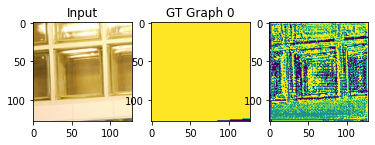

  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.6747268702410445
Validation Loss: 0.4495073819444293
Training Mean IoU: 30.421636557277246
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.82278481012658
Validation Mean Jaccard: 30.666666666666668
Time since start: 360.03033804893494


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.40404488051993936
Validation Loss: 0.4117565779458909
Training Mean IoU: 30.38283818884741
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.78481012658228
Validation Mean Jaccard: 30.666666666666668
Time since start: 693.1736176013947


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.38147798293753515
Validation Loss: 0.3949349359387443
Training Mean IoU: 30.37700749650786
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.78481012658228
Validation Mean Jaccard: 30.666666666666668
Time since start: 1019.1930565834045


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.37443431231039986
Validation Loss: 0.3932117223739624
Training Mean IoU: 30.324434207964547
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.734177215189874
Validation Mean Jaccard: 30.666666666666668
Time since start: 1348.6092178821564


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.35881455129460443
Validation Loss: 0.3795254819449924
Training Mean IoU: 30.407468675058098
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.810126582278482
Validation Mean Jaccard: 30.666666666666668
Time since start: 1674.4431142807007


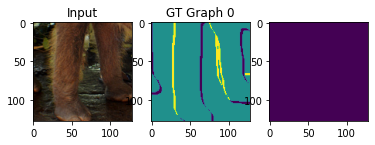

  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.35331703779063645
Validation Loss: 0.37651469664914267
Training Mean IoU: 30.32609480845777
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.72151898734177
Validation Mean Jaccard: 30.666666666666668
Time since start: 2005.9752173423767


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3521046529087839
Validation Loss: 0.3692269843249094
Training Mean IoU: 30.270273329336433
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.670886075949365
Validation Mean Jaccard: 30.666666666666668
Time since start: 2543.5112335681915


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3538432404210296
Validation Loss: 0.3632303199597767
Training Mean IoU: 30.522387444218502
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.936708860759495
Validation Mean Jaccard: 30.666666666666668
Time since start: 2998.129371404648


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3385567540609384
Validation Loss: 0.3693808437812896
Training Mean IoU: 30.362901325467266
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.759493670886076
Validation Mean Jaccard: 30.666666666666668
Time since start: 3517.2542452812195


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3364196819595144
Validation Loss: 0.35541425077688127
Training Mean IoU: 30.659559418883504
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 31.063291139240505
Validation Mean Jaccard: 30.666666666666668
Time since start: 4604.036365032196


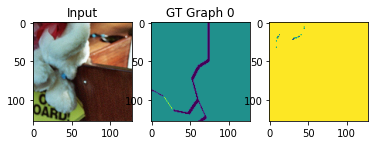

  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.34113877238352086
Validation Loss: 0.3505346108050573
Training Mean IoU: 30.27704195433025
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.68354430379747
Validation Mean Jaccard: 30.666666666666668
Time since start: 5056.28934264183


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3301918966860711
Validation Loss: 0.3537697650137402
Training Mean IoU: 30.48785149296628
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.88607594936709
Validation Mean Jaccard: 30.666666666666668
Time since start: 5386.055501937866


  0%|          | 0/79 [00:00<?, ?it/s]


-- Finished Epoch 10/99 --
Training Loss: 0.3213997639809983
Validation Loss: 0.3492637347607386
Training Mean IoU: 30.55847950223126
Validation Mean IoU: 30.23154540289016
Training Mean Jaccard: 30.949367088607595
Validation Mean Jaccard: 30.666666666666668
Time since start: 5715.562031984329


 97%|█████████▋| 77/79 [04:11<00:06,  3.27s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kenchen10/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-2e4e35ea589d>", line 1, in <module>
    train_log = trainer.train(100, checkpoint=True, start_epoch=start_epoch)
  File "/home/kenchen10/spatial-segmentation/U-Net/Trainer.py", line 133, in train
    loss.backward()
  File "/home/kenchen10/.conda/envs/py38/lib/python3.8/site-packages/torch/tensor.py", line 245, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/kenchen10/.conda/envs/py38/lib/python3.8/site-packages/torch/autograd/__init__.py", line 145, in backward
    Variable._execution_engine.run_backward(
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kenchen10/.conda/envs/py38/lib/python3.8/site

TypeError: object of type 'NoneType' has no len()

In [7]:
train_log = trainer.train(100, checkpoint=True, start_epoch=start_epoch)

## Loading in Model

In [ ]:
folder = 'multi_hinge_lr0.1_momentum0.9_weight_decay0.0001unet_1620001280.298803' 
epoch = 'checkpoint_optim_0_1620001617.0382125'

PATH = '../tests/' + folder + '/' + epoch

def load_checkpoint(model, optimizer, scheduler, filename):
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['start_epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optim'])
        scheduler.load_state_dict(checkpoint['sched'])
        losslogger = checkpoint['log']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['start_epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, scheduler, start_epoch, losslogger

model, optimizer, scheduler, start_epoch, log = load_checkpoint(model, optimizer, scheduler, PATH)
model.eval()
model = model.to(device)

# Results

In [2]:
def plot_predictions(img, graph_pred, graph_target):
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(graph_target.transpose(1, 2, 0)[:, :, 0])
    plt.title("GT Graph 0")
    plt.subplot(1, 3, 3)
#     print(graph_pred.shape)
    if classification:
#         print(np.sum(graph_pred))
        graph_pred = np.squeeze(graph_pred[:, 0, :, :])
#         print(graph_pred.shape)
#         plt.imshow(graph_pred.transpose(1,2,0))
#         print(np.sum(graph_pred))
#         print(np.max(graph_pred))
#         print(np.min(graph_pred))
#         for i in range(3):
#             for j in range(1):
#                 for k in range(5):
#                     print(graph_pred[i, j, k])
#             print('\n')
        graph_pred = np.squeeze(np.argmax(graph_pred, axis=0))
        plt.imshow(graph_pred - 1)
    else:
        plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 0])
        plt.title("Pred Graph 0")
    plt.show()
    
def plot_predictions_dual(img, graph_pred, graph_target, seg_pred, seg_target):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Input")
    plt.subplot(1, 5, 2)
    plt.imshow(graph_target.transpose(1, 2, 0)[:, :, 0])
    plt.title("GT Graph 0")
    plt.subplot(1, 5, 3)
    plt.imshow(graph_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Pred Graph 0")
    plt.subplot(1, 5, 4)
    plt.imshow(seg_target.transpose(1, 2, 0))
    plt.title("GT Segmentation")
    plt.subplot(1, 5, 5)
    plt.imshow(seg_pred.transpose(1, 2, 0)[:, :, 0])
    plt.title("Pred Segmentation")
    plt.show()

In [3]:
arr = np.array([[4, 5, 6, 8], [1, 2, 3, 4]])
arr2 = np.array([[5,1,2,3], [4,3,2,1]])
arr3 = np.array([[8, 9, 1, 2], [1, 4, 3, 2]])
combined = np.stack((arr, arr2, arr3))
print(combined)
np.argmax(combined, axis=0)

NameError: name 'np' is not defined

In [4]:
batch = next(iter(trainer.val_loader))
if DUAL:
    img, (seg_gt, graph_gt), _ = batch
    graph_gt = graph_gt.numpy()
    seg_gt = seg_gt.numpy()
    seg_pred, graph_pred = trainer.evaluate(batch)
else:
    img, gt, _ = batch
    gt = gt.numpy()
    graph_pred = trainer.evaluate(batch)

NameError: name 'trainer' is not defined

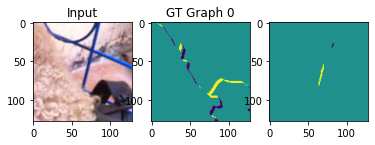

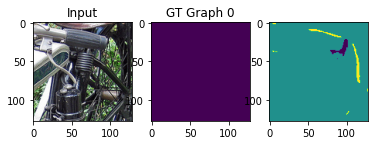

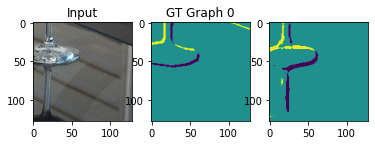

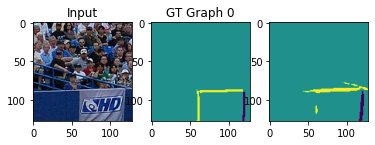

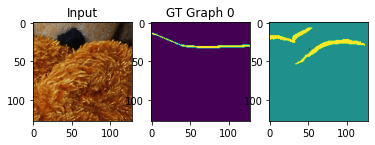

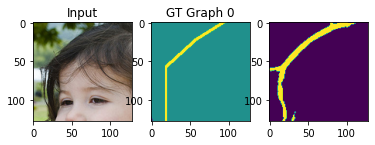

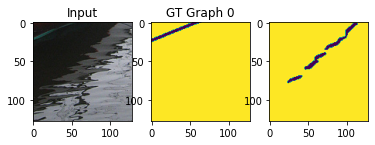

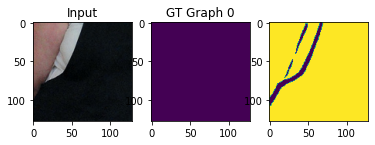

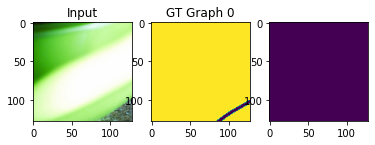

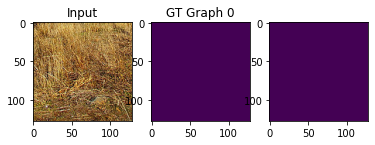

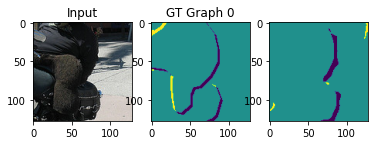

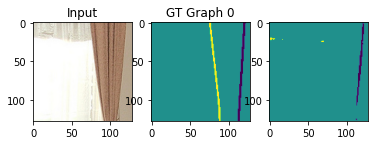

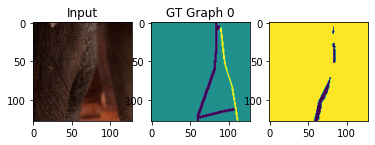

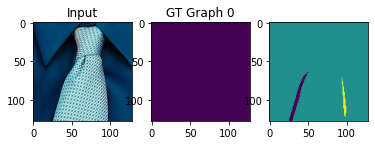

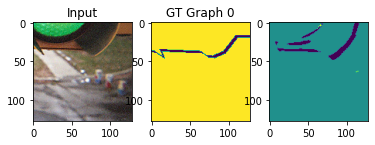

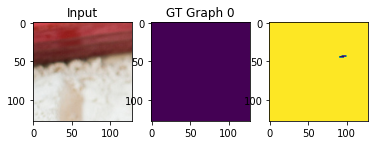

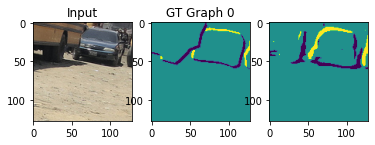

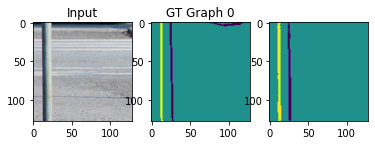

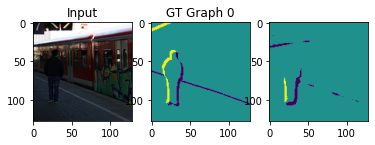

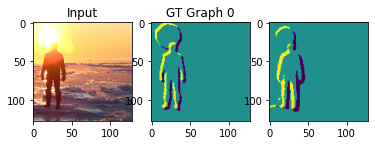

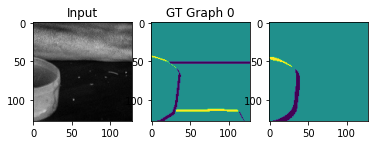

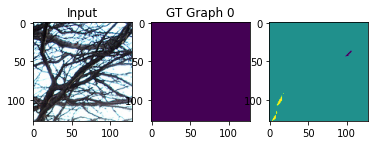

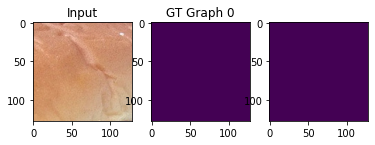

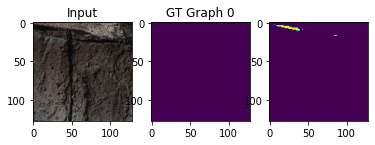

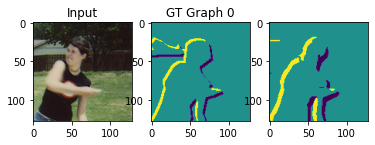

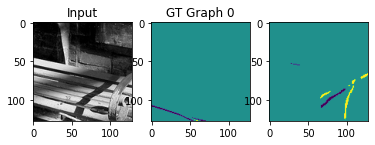

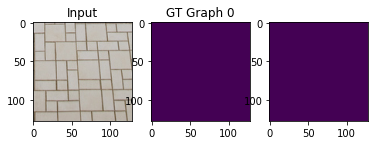

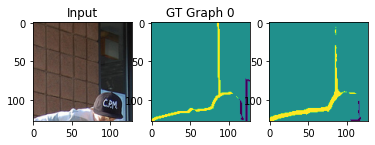

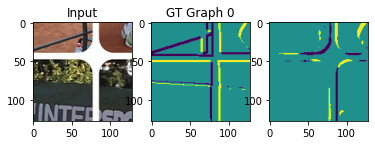

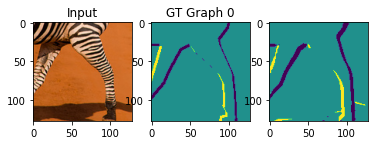

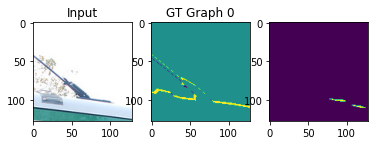

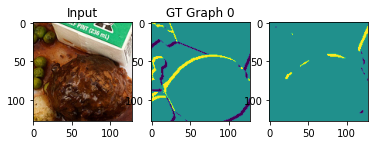

In [13]:
for i in range(len(img)):
# for i in [0]:
    if DUAL:
        plot_predictions_dual(img[i], graph_pred[i], graph_gt[i], seg_pred[i], seg_gt[i])
    else:
        plot_predictions(img[i], graph_pred[i], gt[i])